In [3]:
# import modules
import pandas
from sklearn import svm
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
from pylab import *
import struct
import keras as ks
import logging
from keras.layers import Dense, Activation, Flatten, Convolution2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from skimage import io
import numpy as np
from PIL import Image 
from scipy import misc
import os
# ...

In [28]:
data_raw = pandas.read_csv("data/faultload.csv")
data = np.array(data_raw)

In [86]:
features = data[:, 1:-10]
labels = np.array(data[:, range(-10,0)],dtype=np.int)
plabels = labels
nlabels = []
for item in labels:
    nlabels.append(np.array([0,1,2,3,4,5,6,7,8,9]).dot(item))
labels = np.array(nlabels)
tlabels = np.array(labels).reshape(len(labels), -1)
enc = OneHotEncoder()
enc.fit(tlabels)
oneHotLabels = enc.transform(tlabels).toarray()
for i in range(features.shape[1]):
    fmax = features[:, i].max()
    fmin = features[:, i].min()
    # avoid being divided by zero
    if fmax == fmin:
        features[:, i] = 0
        continue
    features[:, i] -= fmin
    features[:, i] /= (fmax-fmin)

In [87]:
target_names = ['normal', 
                'bono_cpu', 'bono_mem', 'bono_io',
                'homestead_cpu', 'homestead_mem', 'homestead_io',
                'sprout_cpu', 'sprout_mem', 'sprout_io']
# save loss and acc
class LossHistory(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        iindex = np.arange(0,len(self.losses[loss_type]),len(self.losses[loss_type])/100)
        iindex = np.array(iindex, dtype=np.int)
        iters = np.array(iters)
        plt.figure()
        # acc
        plt.plot(iters[iindex], np.array(self.accuracy[loss_type])[iindex], 'r', label='train acc')
        # loss
        plt.plot(iters[iindex], np.array(self.losses[loss_type])[iindex], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters[iindex], np.array(self.val_acc[loss_type])[iindex], 'b', label='val acc')
            # val_loss
            plt.plot(iters[iindex], np.array(self.val_loss[loss_type])[iindex], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        ylim(0,1.5)
        plt.legend(loc="upper right")
        plt.savefig('fig.png')
        
        plt.show()

        
def predict(model,data):
    tmp_res = model.predict(data)
    res = []
    for item in tmp_res:
        res.append(np.where(item == max(item))[0][0])
    return np.array(res)


def nn(f_t, f_tol, f_v, f_vol):
    tlabels = np.array(f_tol).reshape(len(f_tol), -1)
    enc = OneHotEncoder()
    enc.fit(tlabels)
    f_tl = enc.transform(np.array(f_tol).reshape(len(f_tol), -1)).toarray()
    f_vl = enc.transform(np.array(f_vol).reshape(len(f_vol), -1)).toarray()
    
    f_tl = plabels
    f_vl = plabels[501:1000]
    print(f_vl.shape)
    
    model = ks.models.Sequential()
    model.add(Dense(128, input_dim=f_t.shape[1]))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(f_tl.shape[1]))
    model.add(Activation('softmax'))
    history = LossHistory()

    model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
    model.fit(x=f_t,y=f_tl,batch_size=128,nb_epoch=100,verbose=1,validation_data=(f_v,f_vl), callbacks=[history])
    
    print("train acc: {}".format(sum(predict(model,f_t) == f_tol)/len(f_tol)))
    y_true = f_tol
    y_pred = predict(model, f_t)
    print(classification_report(y_true, y_pred, target_names=target_names))

    print("val acc: {}".format(sum(predict(model,f_v) == f_vol)/len(f_vol)))
    y_true = f_vol
    y_pred = predict(model, f_v)
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    return (model, history)


def nsvm(model, f_t, f_tl, f_v, f_vl):
    max_layer = 4
    get_feature = K.function([model.layers[0].input],[model.layers[max_layer].output])
    mid_features_train = get_feature([f_t])[0]
    mid_features_test  = get_feature([f_v])[0]
    clf = svm.SVC()
    clf.fit(mid_features_train, f_tl)

    print("train acc: {}".format(clf.score(mid_features_train, f_tl)))
    y_true = f_tl
    y_pred = clf.predict(mid_features_train)
    print(classification_report(y_true, y_pred, target_names=target_names))

    print("val acc: {}".format(clf.score(mid_features_test, f_vl)))
    y_true = f_vl
    y_pred = clf.predict(mid_features_test)
    print(classification_report(y_true, y_pred, target_names=target_names))

    
def oml(f_t, f_tl, f_v, f_vl):
    classifiers = [
        KNeighborsClassifier(4),
        svm.SVC(kernel="linear", C=0.025),
        svm.SVC(),
        DecisionTreeClassifier(max_depth=3),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    ]
    names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest"]
    for name, clf in zip(names,classifiers):
        clf.fit(f_t, f_tl)
        print(name)
        print("train acc: {}".format(clf.score(f_t, f_tl)))
        y_true = f_tl
        y_pred = clf.predict(f_t)
        print(classification_report(y_true, y_pred, target_names=target_names))

        print("val acc: {}".format(clf.score(f_v, f_vl)))
        y_true = f_vl
        y_pred = clf.predict(f_v)
        print(classification_report(y_true, y_pred, target_names=target_names))
        print('\n')

In [88]:
(model,history) = nn(features, labels, features[501:1000], labels[501:1000])

(499, 10)


/Users/lyq/Anaconda/anaconda2/envs/py3/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 1440 samples, validate on 499 samples
Epoch 1/100
1440/1440 [==============================] - 1s 416us/step - loss: 2.2483 - acc: 0.1674 - val_loss: 2.1025 - val_acc: 0.2625
Epoch 2/100
1440/1440 [==============================] - 0s 29us/step - loss: 1.9182 - acc: 0.3861 - val_loss: 1.5339 - val_acc: 0.5230
Epoch 3/100
1440/1440 [==============================] - 0s 32us/step - loss: 1.4925 - acc: 0.5181 - val_loss: 1.1364 - val_acc: 0.6072
Epoch 4/100
1440/1440 [==============================] - 0s 32us/step - loss: 1.1031 - acc: 0.6757 - val_loss: 0.7003 - val_acc: 0.7916
Epoch 5/100
1440/1440 [==============================] - 0s 30us/step - loss: 0.8611 - acc: 0.7299 - val_loss: 0.7885 - val_acc: 0.7014
Epoch 6/100
1440/1440 [==============================] - 0s 33us/step - loss: 0.7584 - acc: 0.7486 - val_loss: 0.2875 - val_acc: 0.9218
Epoch 7/100
1440/1440 [==============================] - 0s 37us/step - loss: 0.4144 - acc: 0.8875 - val_loss: 0.2495 - val_acc: 0.9138


1440/1440 [==============================] - 0s 30us/step - loss: 0.0214 - acc: 0.9944 - val_loss: 0.0136 - val_acc: 0.9960
Epoch 61/100
1440/1440 [==============================] - 0s 31us/step - loss: 0.0206 - acc: 0.9938 - val_loss: 0.0293 - val_acc: 0.9880
Epoch 62/100
1440/1440 [==============================] - 0s 28us/step - loss: 0.0258 - acc: 0.9944 - val_loss: 0.0143 - val_acc: 0.9960
Epoch 63/100
1440/1440 [==============================] - 0s 32us/step - loss: 0.0205 - acc: 0.9951 - val_loss: 0.0183 - val_acc: 0.9940
Epoch 64/100
1440/1440 [==============================] - 0s 30us/step - loss: 0.0246 - acc: 0.9938 - val_loss: 0.0172 - val_acc: 0.9940
Epoch 65/100
1440/1440 [==============================] - 0s 30us/step - loss: 0.0223 - acc: 0.9951 - val_loss: 0.0122 - val_acc: 0.9960
Epoch 66/100
1440/1440 [==============================] - 0s 30us/step - loss: 0.0196 - acc: 0.9951 - val_loss: 0.0122 - val_acc: 0.9960
Epoch 67/100
1440/1440 [==============================

/Users/lyq/Anaconda/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 9, does not match size of target_names, 10
  .format(len(labels), len(target_names))
/Users/lyq/Anaconda/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 10
  .format(len(labels), len(target_names))


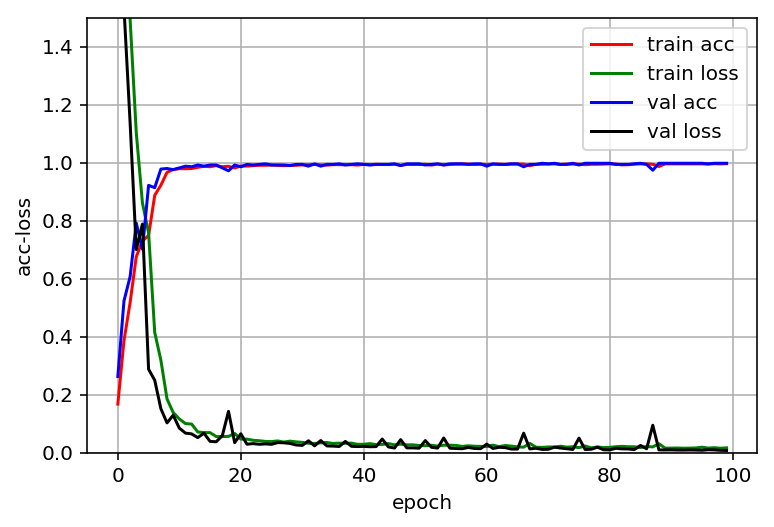

In [90]:
history.loss_plot('epoch')

In [89]:
oml(features, labels, features[501:1000], labels[501:1000])

Nearest Neighbors
train acc: 0.9895833333333334


/Users/lyq/Anaconda/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 9, does not match size of target_names, 10
  .format(len(labels), len(target_names))
/Users/lyq/Anaconda/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 10
  .format(len(labels), len(target_names))
/Users/lyq/Anaconda/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


               precision    recall  f1-score   support

       normal       1.00      0.48      0.65        23
     bono_cpu       1.00      1.00      1.00       192
     bono_mem       1.00      1.00      1.00       191
      bono_io       0.97      1.00      0.99       399
homestead_cpu       1.00      1.00      1.00        36
homestead_mem       0.99      1.00      0.99       240
 homestead_io       1.00      0.95      0.97        60
   sprout_cpu       1.00      1.00      1.00       263
   sprout_mem       1.00      1.00      1.00        36

  avg / total       0.99      0.99      0.99      1440

val acc: 0.9919839679358717
               precision    recall  f1-score   support

       normal       0.00      0.00      0.00         4
     bono_cpu       1.00      1.00      1.00        96
     bono_mem       0.98      1.00      0.99       147
      bono_io       0.99      1.00      0.99        72
homestead_cpu       1.00      1.00      1.00        24
homestead_mem       1.00      1.0

/Users/lyq/Anaconda/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 7, does not match size of target_names, 10
  .format(len(labels), len(target_names))
/Users/lyq/Anaconda/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/lyq/Anaconda/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 9, does not match size of target_names, 10
  .format(len(labels), len(target_names))
/Users/lyq/Anaconda/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 10
  .format(len(labels), len(target_names))
/Users/lyq/Anaconda/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/class

In [92]:
nsvm(model, features, labels, features[501:1000], labels[501:1000])

train acc: 0.9958333333333333
               precision    recall  f1-score   support

       normal       1.00      0.74      0.85        23
     bono_cpu       1.00      1.00      1.00       192
     bono_mem       1.00      1.00      1.00       191
      bono_io       0.99      1.00      0.99       399
homestead_cpu       1.00      1.00      1.00        36
homestead_mem       1.00      1.00      1.00       240
 homestead_io       1.00      1.00      1.00        60
   sprout_cpu       1.00      1.00      1.00       263
   sprout_mem       1.00      1.00      1.00        36

  avg / total       1.00      1.00      1.00      1440

val acc: 0.9979959919839679
               precision    recall  f1-score   support

       normal       1.00      0.75      0.86         4
     bono_cpu       1.00      1.00      1.00        96
     bono_mem       0.99      1.00      1.00       147
      bono_io       1.00      1.00      1.00        72
homestead_cpu       1.00      1.00      1.00        24
hom

/Users/lyq/Anaconda/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 9, does not match size of target_names, 10
  .format(len(labels), len(target_names))
/Users/lyq/Anaconda/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 10
  .format(len(labels), len(target_names))
